In [1]:
# Import necessary packages
import cv2
import numpy as np
import os
from os.path import isfile, join
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from skimage import color
from skimage import io
import shutil

In [2]:
# Defining the path to folders
train_video_path = 'input_video.mp4'
test_video_path = 'test_video.mp4'
train_frames = 'train/'
test_frames = 'test/'

In [3]:
# Function to create the required folders
def create_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
        os.mkdir(folder)
    else:
        os.mkdir(folder)
    print(folder, 'folder created.')

In [4]:
# Create the required folders if not exist
create_folders = False
if create_folders == True:
    for folder in [train_frames, test_frames]:
        create_folder(folder)
else:
    print('Folders already exist')

Folders already exist


In [5]:
# Function to split a video in frames
def video_to_frames(input_video, output_frames):
    vidcap = cv2.VideoCapture(input_video)
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            cv2.imwrite(output_frames+"/image"+str(count)+".jpg", image)
        return hasFrames
    sec = 0
    frameRate = 1/25.0
    count=1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)

In [7]:
# Split the train video in frames and store them in the output folder
video_to_frames(train_video_path, train_frames)
print('Number of train images:', len(os.listdir(train_frames)))

Number of train images: 6077


In [8]:
# Split the test video in frames and store them in the output folder
video_to_frames(test_video_path, test_frames)
print('Number of test images:', len(os.listdir(test_frames)))

Number of test images: 2912


In [6]:
# Defining parameters
BUFFER_SIZE = 400
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [7]:
# Function to normalize an 256x256 image
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [8]:
# Function to load, crop, resize and normalize an image
def load_image(image_file):
    real_image = tf.io.read_file(image_file)
    real_image = tf.image.decode_jpeg(real_image, channels=3)

    real_image = tf.image.resize_with_crop_or_pad(real_image,IMG_HEIGHT, IMG_WIDTH)

    input_image = tf.image.rgb_to_grayscale(real_image)
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [9]:
# Load the train images, create batches and prefetch
train_dataset = tf.data.Dataset.list_files(train_frames+'*.jpg')
train_dataset = train_dataset.map(load_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [10]:
# Load the test images, create batches and prefetch
test_dataset = tf.data.Dataset.list_files(test_frames+'*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
# Function to display grayscale and color images
def generate_two_images(input, tar):
  plt.figure(figsize=(15,15))
  display_list = [tf.squeeze(input[0]), tf.squeeze(tar[0])]
  title = ['Input Image', 'Color Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i]*0.5 + 0.5)
    plt.axis('off')
  plt.show()

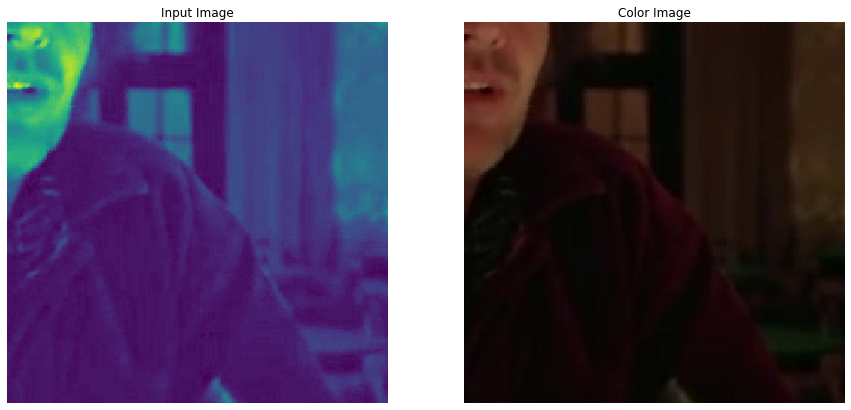

In [12]:
# Display two images to compare
for example_input, example_target in train_dataset.take(1):
  generate_two_images(example_input, example_target)

In [13]:
# Define the downsample
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [14]:
# Define the upsample
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [15]:
# Define the Generator
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

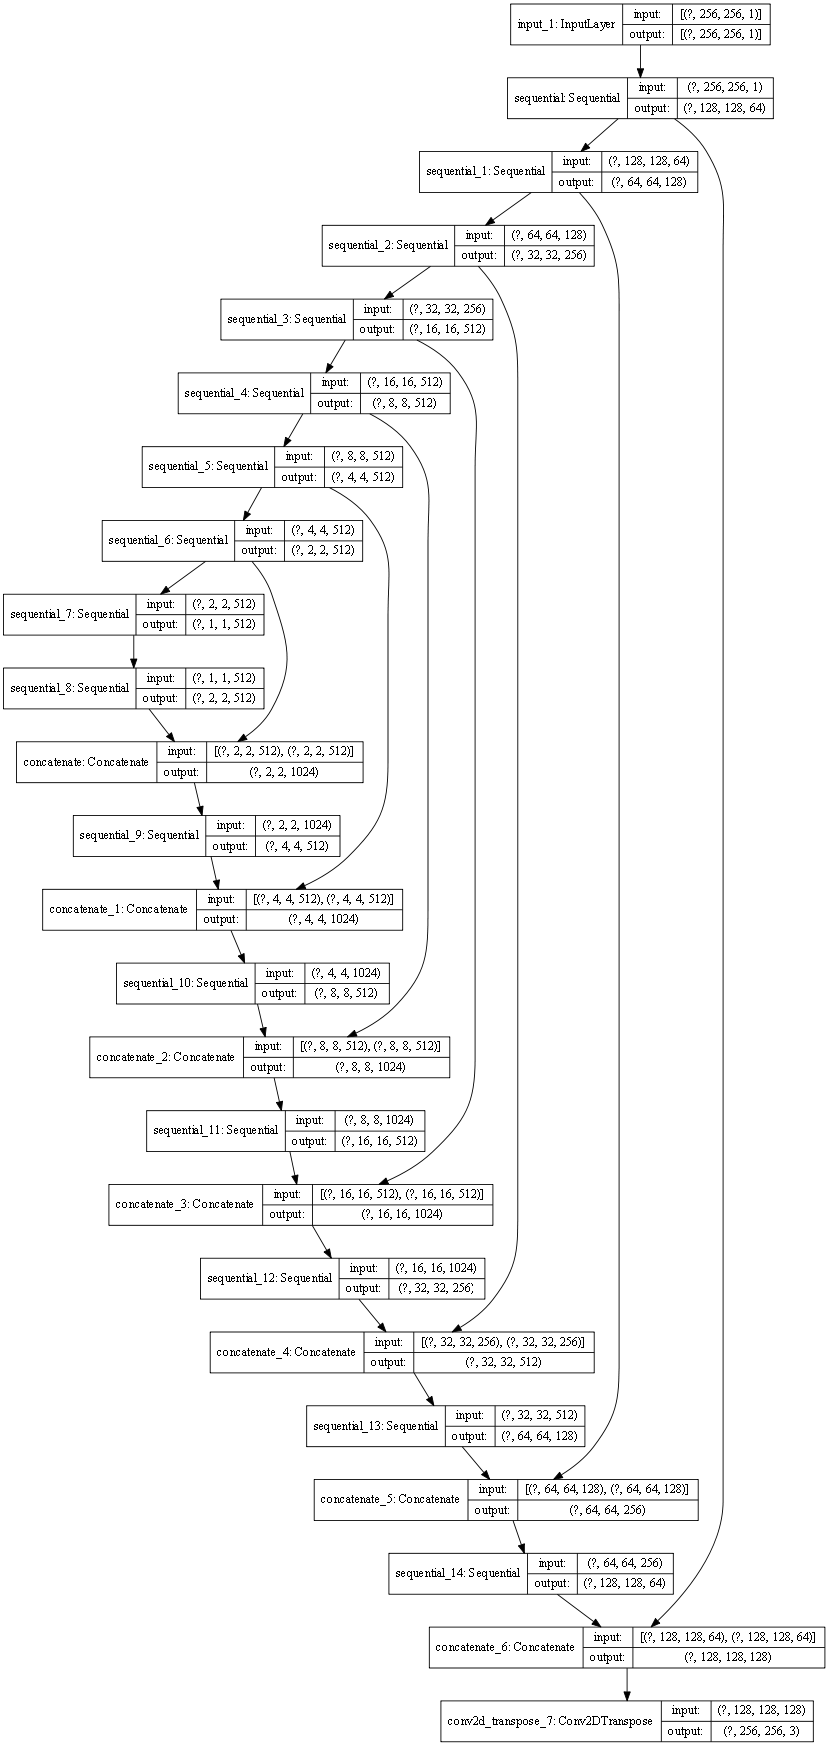

In [16]:
# Initialize the Generator and display its layers
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [17]:
LAMBDA = 100

In [18]:
# Define the Generator loss
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [19]:
# Define the Discriminator
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

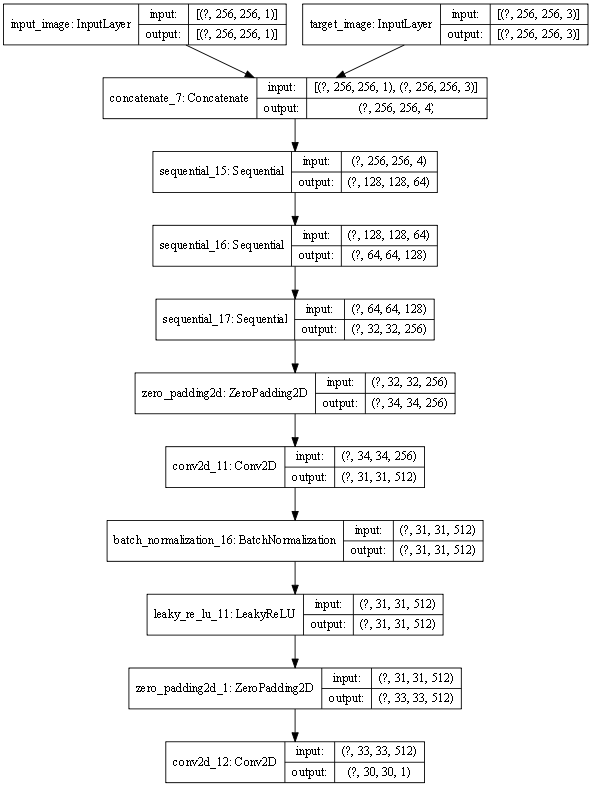

In [20]:
# Initialize the Discriminator and display its layers
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# Define the Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [23]:
# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
# Function to display 3 images for comparision: grayscale, original and predicted
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [tf.squeeze(test_input[0]), tf.squeeze(tar[0]), tf.squeeze(prediction[0])]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

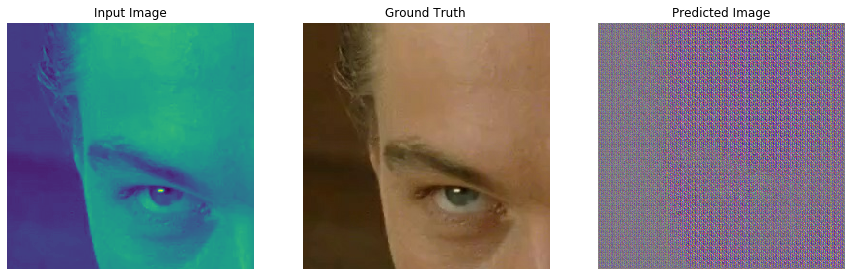

In [25]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [26]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [27]:
# Define the training process
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [28]:
# Define the fit process
from IPython import display
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

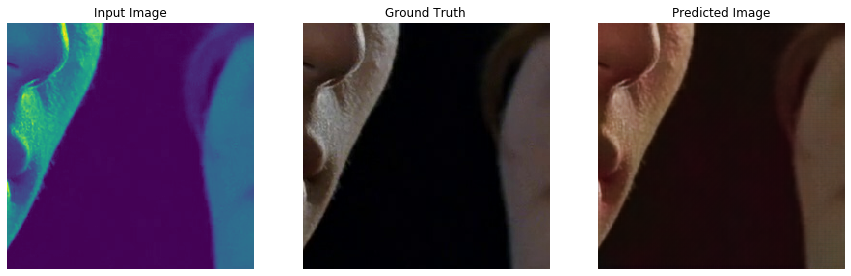

Epoch:  59
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

In [29]:
# Fit the model for the desired number of epochs
EPOCHS = 60
fit(train_dataset, EPOCHS, test_dataset)

In [30]:
# Save only the generator indicating the number of training epochs
generator.save('model_'+str(EPOCHS)+'_trained.h5')

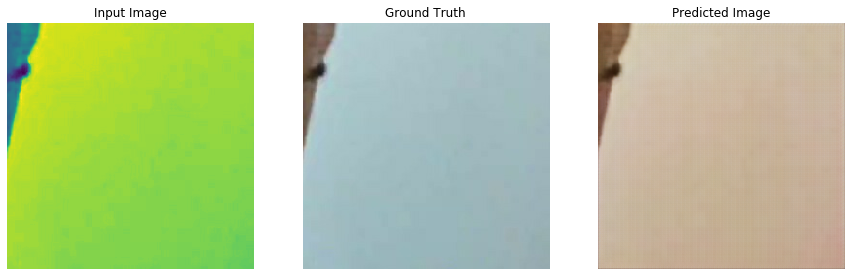

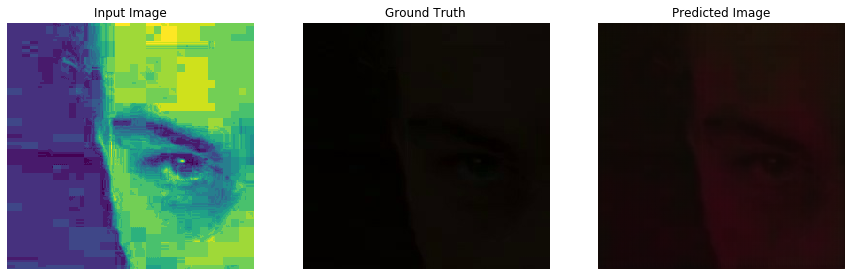

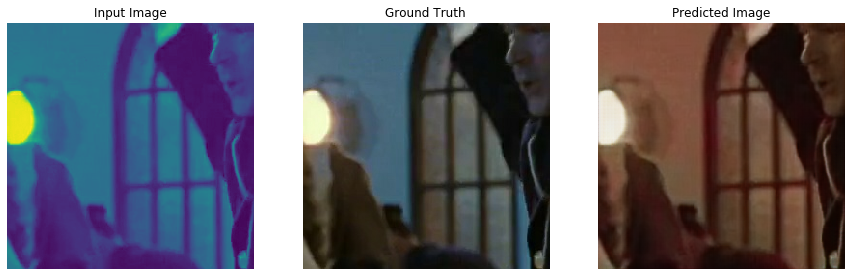

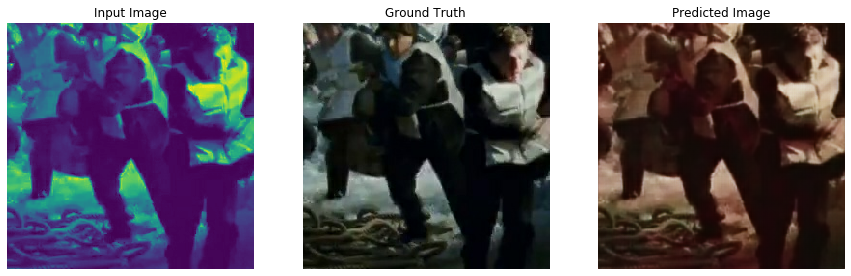

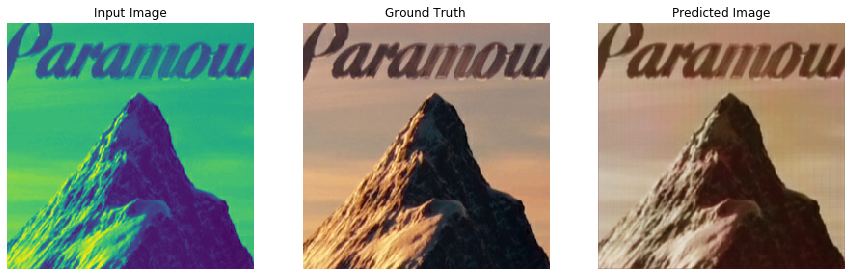

In [31]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)